## Specific Test III: Learning Mass of Dark Matter Halo 

`Task`: Using the provided dataset implement a regression algorithm to learn the mapping between lensing images and the lensing dark matter halo mass. You can use the machine learning algorithm of your choice.  Please implement your approach in PyTorch or Keras and discuss your strategy.

`Dataset`: [lens_data_alt.tgz](https://drive.google.com/file/d/1hu472ALwGPBcTCXSAM0VoCWmTktg9j-j/view) - Google Drive

`Dataset Description`: The data set consists of strong lensing images for cold dark matter with subhalo substructure. For each lensing image the corresponding fraction of mass in dark matter substructure is provided.
`Evaluation Metrics`: MSE (mean squared error)

In [1]:
!gdown "1hu472ALwGPBcTCXSAM0VoCWmTktg9j-j&confirm=t"

Downloading...
From: https://drive.google.com/uc?id=1B_UZtU4W65ZViTJsLeFfvK-xXCYUhw2A&confirm=t
To: /content/dataset.zip
100% 1.13G/1.13G [00:08<00:00, 129MB/s]


In [2]:
! mkdir test_3

! tar xvzf lens_data_alt.tgz -C test_3

In [6]:
! pip install timm -q

In [3]:

import os
import json
import random
import numpy as np
from glob import glob
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import timm
import torch
import torch.nn as nn
from torch import nn, optim
import torch.nn.functional as F
from torch.optim import Adam, SGD
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader


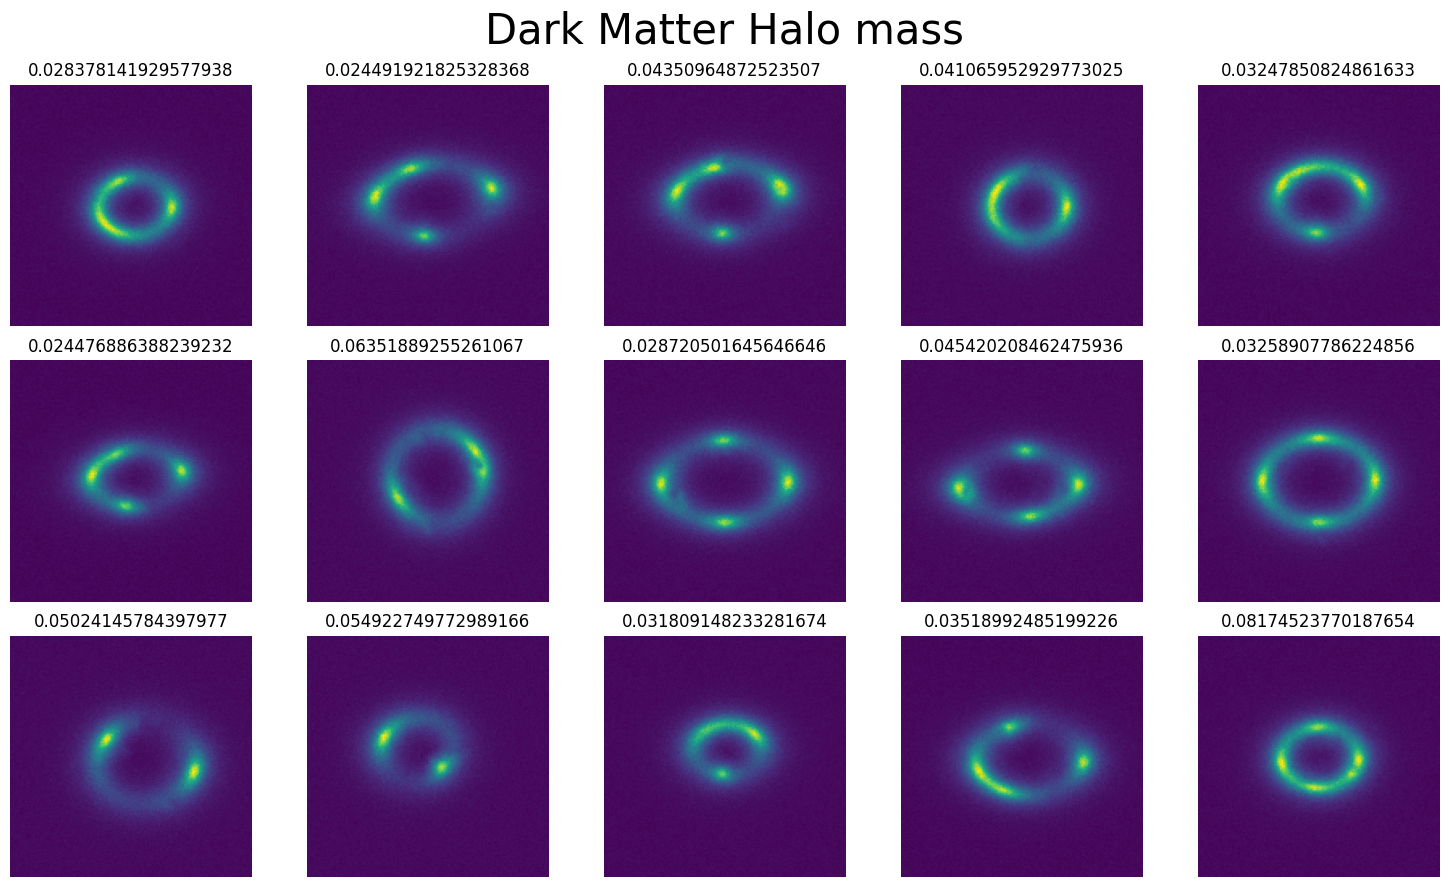

In [4]:

def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0: 
       return v
    return v / norm


def show_imgs(rows= 3 , cols = 5):

    n_imgs = cols * rows
    paths = random.sample(glob(f"test_3\lens_data\*.npy"), k = n_imgs)


    fig, axs = plt.subplots(rows, cols, figsize=(15, 9))
    axs = axs.flatten()
    for path, ax in zip(paths, axs):
        arr, mass = np.load(path, allow_pickle=True)
        img = normalize(arr)
        ax.imshow(img)
        ax.title.set_text(f"{mass}")
        ax.axis('off')
    plt.suptitle(f"Dark Matter Halo mass", fontsize=30)
    plt.tight_layout()

    plt.savefig(Path('assets')/f"Dark Matter Halo mass.png", dpi = 600)
    plt.show()

show_imgs()

In [5]:


image_transforms = {
    "train": transforms.Compose([
        transforms.ToTensor(),
        transforms.CenterCrop(120),
        transforms.Resize(224),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation([-75, +75]),

    ]),
    "val": transforms.Compose([
        transforms.ToTensor(),
        transforms.CenterCrop(120),
        transforms.Resize(224)
    ])
}

In [6]:


files = glob("test_3/lens_data/*")

train_files, test_files = train_test_split(files, test_size = 0.1, random_state = 42)

len(train_files)

18000

In [7]:


class HaloMassData(Dataset):
    def __init__(self, files, transform):
        self.files =  files
        self.transform = transform

    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, i):
        arr, mass = np.load(self.files[i], allow_pickle=True)
        arr = normalize(arr)
        arr = self.transform(arr)[0]
        arr= torch.stack([arr,arr,arr])
        return arr.to(torch.float32), torch.tensor([mass]).to(torch.float32)
    
train_dset = HaloMassData(train_files, image_transforms["train"])
val_dset = HaloMassData(test_files, image_transforms["val"])

In [8]:
train_dset.__getitem__(34)[0].shape

torch.Size([3, 224, 224])

In [9]:

class Trainer:
    # DONE: Implement model save and load properly
    # DONE: Maintaining epoch number while saving and resuming 
    # DONE: Adding comments and explanations
    def __init__(self, model_name, model, train_dset, val_dset, loss_type, optim_type, batch_size, load = False):
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model_name = model_name
        self.model_dir = Path(model_name)
        
        if load:
            self.model_dir.mkdir(exist_ok=True)
        else:
            self.model_dir.mkdir()

        self.model = model.to(self.device)
        self.train_dset = train_dset
        self.val_dset = val_dset

        self.train_loader = self.get_dataloader(dl_type = "train" , batch_size = batch_size)
        self.val_loader = self.get_dataloader(dl_type = "val" , batch_size = batch_size)
        self.loss_fn = self.get_loss(loss_type)
        self.optimizer = self.get_optimizer(optim_type)
        
        self.nmse = lambda out, tgt: torch.mean(torch.sqrt(F.mse_loss(out, tgt, reduction='none'))/(tgt + 1e-9))
        self.model.to(self.device)

        self.info_dict = {}

        self.info_dict["last_epoch"] = -1
        self.info_dict["best_mse"] = 1000

    def get_loss(self, loss_type):
        if loss_type == "ce":
            return nn.CrossEntropyLoss(reduction='sum')
        elif loss_type == "mse":
            return nn.MSELoss(reduction='sum')
        else:
            raise TypeError("This loss type is supported for now") 
    
    def get_optimizer(self, optim_type):
        if optim_type == "adam":
            return Adam(self.model.parameters(), lr=1e-4)
        elif optim_type == "sgd":
            return SGD(self.model.parameters(), lr=0.1, momentum=0.9)
        else:
            raise TypeError("This optimizer type is not yet supported") 

    
    def get_dataloader(self, dl_type , batch_size):
        if dl_type == "train":
            return DataLoader(self.train_dset, batch_size=batch_size, shuffle=True)
        elif dl_type == "val":
            return DataLoader(self.val_dset, batch_size=batch_size, shuffle=False)
        else:
            raise TypeError("Only support train and validation dataloader currently.")

    def train_one_epoch(self):
        self.model.train()
        train_loss = 0.0
        train_nmse = 0.0
        correct = 0
        total = 0
        
        for _, (data, target) in enumerate(tqdm(self.train_loader)):
            data, target = data.to(self.device), target.to(self.device)
            
            self.optimizer.zero_grad()
            output = self.model(data)
            # print(output[:5])
            # print(target[:5])
            loss = self.loss_fn(output, target)
            loss.backward()
            self.optimizer.step()
            
            train_loss += loss.item()
            train_nmse += self.nmse(output, target).item() * data.shape[0]
            # total += 1
            # mse_sum += torch.nn.functional.mse_loss(input, target, size_average=None, reduce=None, reduction='mean')
            
        train_loss /= len(self.train_loader.dataset)
        train_nmse /= len(self.train_loader.dataset)
        
        return train_loss, train_nmse
    
    def val_one_epoch(self):
        self.model.eval()
        val_loss = 0.0
        val_nmse = 0.0
        
        with torch.no_grad():
            for _, (data, target) in enumerate(tqdm(self.val_loader)):
                data, target = data.to(self.device), target.to(self.device)
                
                output = self.model(data)
                loss = self.loss_fn(output, target)
                
                val_loss += loss.item()
                val_nmse += self.nmse(output, target).item() * data.shape[0]
                # _, predicted = output.max(1)
                # total += target.size(0)
                # correct += predicted.eq(target).sum().item()
                
        val_loss /= len(self.val_loader.dataset)
        val_nmse /= len(self.val_loader.dataset)
        
        return val_loss, val_nmse
    
    def run_training(self, num_epochs, run_valid = True, patience = 5):

        self.start_epoch = self.info_dict["last_epoch"] + 1

        if "train_loss_history" not in self.info_dict.keys():
            self.info_dict["train_loss_history"] = []

        if "train_nmse_history" not in self.info_dict.keys():
            self.info_dict["train_nmse_history"] = []
        
        current_patience = patience
        for epoch in range(self.start_epoch, self.start_epoch + num_epochs):
            train_loss, train_nmse = self.train_one_epoch()
            
            self.info_dict["last_epoch"] = epoch
            self.info_dict["train_loss_history"].append(train_loss)
            self.info_dict["train_nmse_history"].append(train_nmse)
            
            print('Epoch {}/{}: Train Loss(MSE): {:.6f} Train NRMSE: {:.6f}'.format(epoch+1, num_epochs, train_loss,train_nmse))
            
            if run_valid:
                isBest  = self.run_validation()

                if isBest:
                    current_patience = patience
                else:
                    current_patience -= 1
                    print(f"Patience reduced to {current_patience}.")
                    if current_patience == 0:
                        print(f"Validation not improving from last {patience} epochs. Stopping early.")
                        break
            self.save_json()

    def run_validation(self):

        if "val_loss_history" not in self.info_dict.keys():
            self.info_dict["val_loss_history"] = []

        if "val_nmse_history" not in self.info_dict.keys():
            self.info_dict["val_nmse_history"] = []

        val_loss, val_nmse = self.val_one_epoch()

        self.info_dict["val_loss_history"].append(val_loss)
        self.info_dict["val_nmse_history"].append(val_nmse)
        
        print('Validation Loss(MSE): {:.6f}  Val NRMSE: {:.6f}'.format(val_loss, val_nmse))

        if val_loss < self.info_dict["best_mse"]:
            print(f"Got improved  validation MSE: {val_loss:.10f}")
            self.save('best_ckpt.pth')
            self.info_dict["best_mse"] = val_loss

            return True
        return False



    def save_json(self, json_path = "model.json"):
        with open(self.model_dir/json_path, 'w') as f:
            json.dump(self.info_dict, f, ensure_ascii=False)


    def save(self, path):
        torch.save({
            'epoch': self.info_dict["last_epoch"],
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict()
            }, self.model_dir/path)
        torch.save(self.model.state_dict(), path)

        self.save_json()
        
    def load(self, path, json_path = "model.json"):

        ckpt = torch.load(path)
        self.info_dict["last_epoch"] = ckpt['epoch']
        self.model.load_state_dict(ckpt['model_state_dict'])
        self.optimizer.load_state_dict(ckpt['optimizer_state_dict'])

        if json_path:
            with open(json_path) as json_file:
                self.info_dict = json.load(json_file)
                
    def plot_mse(self):
        plt.plot(self.info_dict['train_loss_history'] , label='Train MSE')
        plt.plot(self.info_dict['val_loss_history'] , label='Validation MSE')
        plt.title(f'{self.model_name} - MSE')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy value')
        plt.legend(loc="upper right")
        plt.savefig(self.model_dir/f"{self.model_name} - MSE.png", dpi = 600)
        plt.show()


    def plot_nrmse(self):
        plt.plot(self.info_dict['train_nmse_history'] , label='Train NRMSE')
        plt.plot(self.info_dict['val_nmse_history'] , label='Validation NRMSE')
        plt.title(f'{self.model_name} - NRMSE')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy value')
        plt.legend(loc="upper right")
        plt.savefig(self.model_dir/f"{self.model_name} - NRMSE.png", dpi = 600)
        plt.show()


In [10]:


class TimmLensModel(nn.Module):
    def __init__(self, model_name):
        super(TimmLensModel, self).__init__()
        
        self.cnn_model = timm.create_model(model_name, pretrained = True, num_classes = 1)

        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.cnn_model(x)
        x = self.sigmoid(x)/10
        
        return x
    


## Training

In [11]:

model_name = 'convnext_pico'
timm_resnet = TimmLensModel(model_name)
trainer = Trainer(model_name,
                  model = timm_resnet, 
                  train_dset=train_dset,
                  val_dset= val_dset,
                  loss_type="mse",
                  optim_type="adam",
                  batch_size = 64,
                  )

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'convnext_pico'

In [36]:
trainer.run_training(50)

  0%|          | 0/282 [00:00<?, ?it/s]

Epoch 1/50: Train Loss(MSE): 0.000222 Train NRMSE: 0.359312


  0%|          | 0/32 [00:00<?, ?it/s]

Validation Loss(MSE): 0.000218  Val NRMSE: 0.374393
Got improved  validation MSE: 0.0002176166


  0%|          | 0/282 [00:00<?, ?it/s]

Epoch 2/50: Train Loss(MSE): 0.000215 Train NRMSE: 0.355113


  0%|          | 0/32 [00:00<?, ?it/s]

Validation Loss(MSE): 0.000217  Val NRMSE: 0.371471
Got improved  validation MSE: 0.0002167975


  0%|          | 0/282 [00:00<?, ?it/s]

Epoch 3/50: Train Loss(MSE): 0.000215 Train NRMSE: 0.354844


  0%|          | 0/32 [00:00<?, ?it/s]

Validation Loss(MSE): 0.000217  Val NRMSE: 0.372677
Patience reduced to 4.


  0%|          | 0/282 [00:00<?, ?it/s]

Epoch 4/50: Train Loss(MSE): 0.000215 Train NRMSE: 0.354085


  0%|          | 0/32 [00:00<?, ?it/s]

Validation Loss(MSE): 0.000217  Val NRMSE: 0.372642
Patience reduced to 3.


  0%|          | 0/282 [00:00<?, ?it/s]

Epoch 5/50: Train Loss(MSE): 0.000214 Train NRMSE: 0.354681


  0%|          | 0/32 [00:00<?, ?it/s]

Validation Loss(MSE): 0.000216  Val NRMSE: 0.369273
Got improved  validation MSE: 0.0002162384


  0%|          | 0/282 [00:00<?, ?it/s]

Epoch 6/50: Train Loss(MSE): 0.000214 Train NRMSE: 0.354313


  0%|          | 0/32 [00:00<?, ?it/s]

Validation Loss(MSE): 0.000214  Val NRMSE: 0.352100
Got improved  validation MSE: 0.0002140168


  0%|          | 0/282 [00:00<?, ?it/s]

Epoch 7/50: Train Loss(MSE): 0.000214 Train NRMSE: 0.354028


  0%|          | 0/32 [00:00<?, ?it/s]

Validation Loss(MSE): 0.000217  Val NRMSE: 0.372824
Patience reduced to 4.


  0%|          | 0/282 [00:00<?, ?it/s]

Epoch 8/50: Train Loss(MSE): 0.000214 Train NRMSE: 0.354996


  0%|          | 0/32 [00:00<?, ?it/s]

Validation Loss(MSE): 0.000215  Val NRMSE: 0.361432
Patience reduced to 3.


  0%|          | 0/282 [00:00<?, ?it/s]

Epoch 9/50: Train Loss(MSE): 0.000214 Train NRMSE: 0.353867


  0%|          | 0/32 [00:00<?, ?it/s]

Validation Loss(MSE): 0.000216  Val NRMSE: 0.368622
Patience reduced to 2.


  0%|          | 0/282 [00:00<?, ?it/s]

Epoch 10/50: Train Loss(MSE): 0.000214 Train NRMSE: 0.354723


  0%|          | 0/32 [00:00<?, ?it/s]

Validation Loss(MSE): 0.000214  Val NRMSE: 0.354784
Patience reduced to 1.


  0%|          | 0/282 [00:00<?, ?it/s]

Epoch 11/50: Train Loss(MSE): 0.000214 Train NRMSE: 0.354291


  0%|          | 0/32 [00:00<?, ?it/s]

Validation Loss(MSE): 0.000214  Val NRMSE: 0.351103
Patience reduced to 0.
Validation not improving from last 5 epochs. Stopping early.


## Evaluation

### If you are here to evaluate already trained models, this  section is for you.

`Step 1`: Download the model weights (and optionally model.json file) from links in README.md

`Step 2`: Run this notebook upto defining  the Trainer class. No need to run the training block.

`Step 3`: Replace the `model_name`, `json_path` and `weight_path` in the next cell.

Now, run the next cells, and  it will plot the Evaluation metrics as   well as training curves for corresponding model.

In [12]:
model_name = 'convnext_pico'
json_path = r"convnext_pico\model.json"
weight_path =r"convnext_pico\best_ckpt.pth"

# Creating model for usage
timm_resnet = TimmLensModel(model_name)

# Creating Trainer  object
trainer = Trainer(model_name,
                  model = timm_resnet, 
                  train_dset=train_dset,
                  val_dset= val_dset,
                  loss_type="mse",
                  optim_type="adam",
                  batch_size = 64,
                  load =True
                  )

trainer.load(path=weight_path, json_path=json_path)

## Plotting

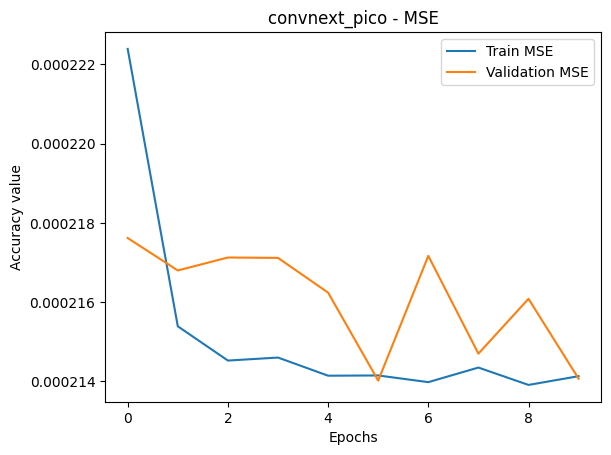

In [13]:
trainer.plot_mse()

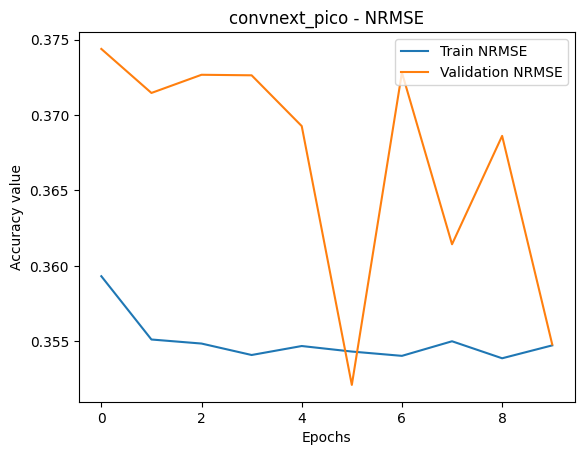

In [14]:
trainer.plot_nrmse()